## Heat capacity estimators for canonical and NPT ensemble.
### Taking the second derivative of an estimated function does not make any sense. Thus, instead of getting heat capacities from Free energy estimations, I will try to come up with a model directly estimating heat capacities. 

In [63]:
from pyiron import Project
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from numpy import save
import pickle
from pycalphad import Database, calculate
db = Database('unary50.tdb')
%matplotlib notebook

In [39]:
def make_energy_job(project, basis, potential, strain_list):
    project_basis = project.create_group(list(basis.info.keys())[0])
    for strain in strain_list:
        strain_structure = basis.copy()
        strain_structure.set_cell(cell=basis.cell*strain**(1/3),
                                    scale_atoms=True)
        
        job_ref = project_basis.create_job(job_type=pr.job_type.Lammps,
                                           job_name='energyjob'+str(strain).replace('.','_'), 
                                           delete_existing_job=True)
        job_ref.structure = strain_structure
        job_ref.potential = potential

        job_ref.calc_minimize(ionic_energy_tolerance=1e-10,
                              ionic_force_tolerance=1e-12,
                              max_iter=10000,
                              pressure=None)
        job_ref.run()
    return len(basis)
def energy_volume_pairs(pr):
    volume_lst, energy_lst = zip(*[[job['output/generic/volume'][-1], job['output/generic/energy_pot'][-1]]
                               for job in pr.iter_jobs(convert_to_object=False) if 'energyjob' in job.job_name])
    return volume_lst, energy_lst

def make_phonopy_job(project, basis, potential, disp):
    basis_name = list(basis.info.keys())[0]
    pr_phon = project

    ref_job = pr_phon.create_job(pr.job_type.Lammps,'phononjob_ref')
    ref_job.structure = basis.copy()
    ref_job.potential = potential
    
    phonopy_job = pr_phon.create_job(pr.job_type.PhonopyJob,basis_name+str(disp).replace('.','_'), delete_existing_job=True)
    phonopy_job.ref_job = ref_job
    phonopy_job.input['primitive_matrix'] = 'auto'

    phonopy_job.input['displacement'] = disp

    phonopy_job.server.cores = 4
    phonopy_job.server.queue = 'cmti'
    phonopy_job.server.run_time = 1000
    phonopy_job.run()

In [3]:
# Create a project
project_name = 'heat_capacity_Ca1'

pr = Project(path=project_name)

In [49]:
bcc_basis = pr.create_ase_bulk(name='Ca', crystalstructure='bcc', a=4.41,
                                cubic=True)

fcc_basis = pr.create_ase_bulk(name='Ca', crystalstructure='fcc', a=5.576,
                                cubic=True)


fcc_6 = fcc_basis.repeat([6, 6, 6])
bcc_7 = bcc_basis.repeat([7, 7, 7])
# for phonons
fcc_3 = fcc_basis.repeat([3, 3, 3])
bcc_4 = bcc_basis.repeat([4, 4, 4])

 #list(fcc_basis.info.keys())[0]
bcc_basis.info = {'bcc':'bcc'}
fcc_basis.info = {'fcc':'fcc'}

fcc_6.info = {'fcc_6':'fcc_6'}
bcc_7.info = {'bcc_7':'bcc_7'}

fcc_3.info = {'fcc_3':'fcc_3'}
bcc_4.info = {'bcc_4':'bcc_4'}

base_potential = 'Morse_Shifted_GirifalcoWeizer_1959HighCutoff_Ca__MO_159753408472_004'
base_structures = [bcc_7,fcc_6]
strain_list = np.around(np.linspace(1.0, 1.0, num=1),decimals=3)
temp_list = [600, 700, 800, 900, 1000, 1100]

# This is for bm
strain_list_bm = np.around(np.linspace(0.94, 1.06, num=7),decimals=3)

# Create BM (birch murnaghan) jobs

In [5]:
pr_bm = pr.create_group('BM')
murn = pr_bm.create_job(job_type=pr.job_type.Murnaghan, job_name='murn')

murndata = []
vols = []
ens = [] 
for base in base_structures:
    atom_size = make_energy_job(pr_bm, base, base_potential, strain_list_bm)
    volume_lst, energy_lst = energy_volume_pairs(pr_bm[list(base.info.keys())[0]])
    volume_lst= [i/atom_size for i in volume_lst]
    energy_lst= [i/atom_size for i in energy_lst]
    
    [e0, b0, bP, v0], [e0_error, b0_error, bP_error, v0_error] = murn._fit_leastsq(volume_lst=volume_lst,
                                                                               energy_lst=energy_lst,
                                                                               fittype='birchmurnaghan')
    murndata.append([e0, b0, bP, v0])
    vols.append(volume_lst)
    ens.append(energy_lst)

The job energyjob0_94 was saved and received the ID: 14701385
The job energyjob0_96 was saved and received the ID: 14701388
The job energyjob0_98 was saved and received the ID: 14701389
The job energyjob1_0 was saved and received the ID: 14701391
The job energyjob1_02 was saved and received the ID: 14701393
The job energyjob1_04 was saved and received the ID: 14701395
The job energyjob1_06 was saved and received the ID: 14701396
The job energyjob0_94 was saved and received the ID: 14701399
The job energyjob0_96 was saved and received the ID: 14701401
The job energyjob0_98 was saved and received the ID: 14701402
The job energyjob1_0 was saved and received the ID: 14701405
The job energyjob1_02 was saved and received the ID: 14701407
The job energyjob1_04 was saved and received the ID: 14701408
The job energyjob1_06 was saved and received the ID: 14701409


<IPython.core.display.Javascript object>


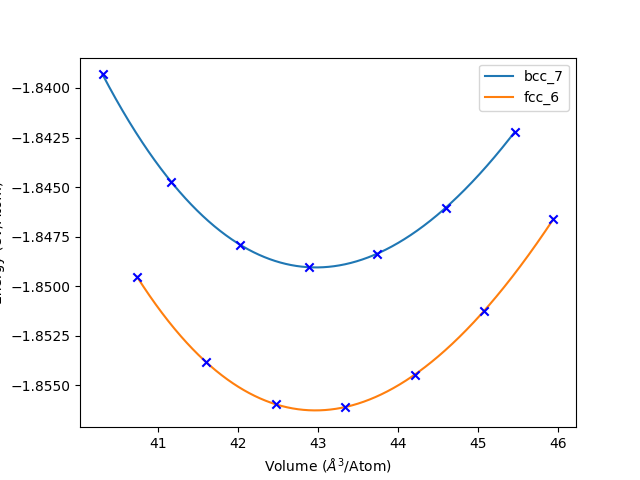

In [7]:
plt.figure()
labels = [list(base.info.keys())[0] for base in base_structures]
for i,j,k, label in zip(murndata, vols, ens, labels):
    vol_lst = np.linspace(min(j), max(j), 1000)
    
    plt.scatter(j, k, marker='x', color='b',zorder=5)
    plt.plot(vol_lst, murn.fit_module.birchmurnaghan_energy(vol_lst, i[0], i[1]/ 160.21766208, i[2], i[3]), label=label)

plt.xlabel('Volume ($\AA ^ 3$/Atom)')
plt.ylabel('Energy (eV/Atom)')
plt.legend()
plt.show()

# Create Phonon Jobs

In [50]:
pr_phonon = pr.create_group('PHONON')
#base_structures_for_phonon = [bcc_7,fcc_6, bcc_basis, fcc_basis, bcc_4,fcc_3,]
base_structures_for_phonon = [bcc_4,fcc_3]
disps = [0.01, 0.64]
for base in base_structures_for_phonon:
    for disp in disps:
        make_phonopy_job(pr_phonon, base, base_potential, disp)

The job bcc_40_01 was saved and received the ID: 14705958
Queue system id:  2178212
The job bcc_40_64 was saved and received the ID: 14705959
Queue system id:  2178213
The job fcc_30_01 was saved and received the ID: 14705960
Queue system id:  2178214
The job fcc_30_64 was saved and received the ID: 14705961
Queue system id:  2178215


In [51]:
pr_phonon.list_nodes()

['fcc_30_64',
 'bcc_40_64',
 'fcc_30_01',
 'bcc_40_01',
 'fcc_60_01',
 'fcc_60_64',
 'bcc_70_01',
 'bcc_70_64',
 'fcc0_64',
 'bcc0_64',
 'fcc0_01',
 'bcc0_01']

fcc_30_01


<IPython.core.display.Javascript object>


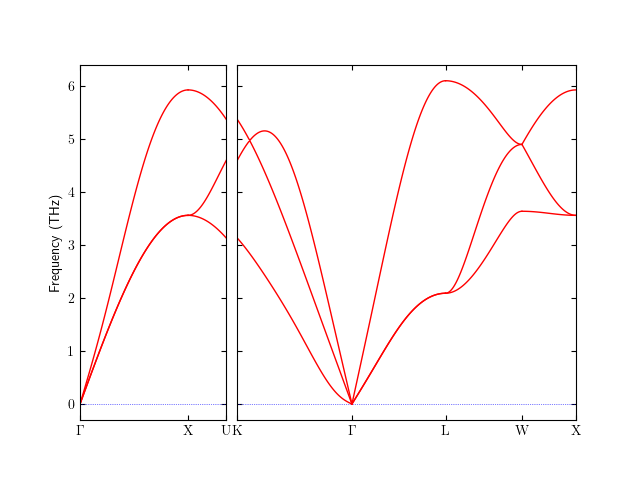

Scaled distances:  [(0.0, 2.038322950394926), (2.038322950394926, 2.758978940631135), (2.758978940631135, 4.9209469113397715), (4.9209469113397715, 6.686186367498614), (6.686186367498614, 8.127498347971066), (8.127498347971066, 9.146659823168525)]
Minimum frequency (THz):  0.1434499347597778


In [66]:
for pjob in pr_phonon.list_nodes():
    pjob = 'fcc_30_01'
    print(pjob)
    phonopy_t = deepcopy(pr_phonon[pjob].phonopy)
    fc2 = phonopy_t.force_constants
    phonopy_t.auto_band_structure(plot=True)
    phonopy_t.auto_total_dos(mesh=[20,20,20], plot=False)
    print('Minimum frequency (THz): ', phonopy_t.get_mesh_dict()['frequencies'].min())
    save('fc.npy', fc2)
    with open('phonopy_obj.pickle', 'wb') as f:
        pickle.dump(phonopy_t, f)
    break

# Create CV jobs

In [ ]:
# job_template = pr.create_group('CV').create_job(pr.job_type.Lammps, "lmp_template")
# job_template.potential = base_potential
# job_template.server.cores = 4
# job_template.server.queue = 'cmti'
# job_template.server.run_time = 200000

# for structure in base_structures:
#     for strain in strain_list:
#         for temp in temp_list:
#             for tdamp in [100]:
#                 for nprint in [40]:
#                     job_name = 'K'+str(temp)+'_tdamp'+str(tdamp)+'_nprint'+str(nprint)+'_'+list(structure.info.keys())[0]+'_strain'+str(strain).replace('.','_')
#                     job = job_template.copy_to(new_job_name=job_name, new_database_entry=False)
                        
#                     strain_structure = structure.copy()
#                     strain_structure.set_cell(cell=structure.cell*strain**(1/3),
#                                               scale_atoms=True)
#                     job.structure = strain_structure

#                     job.calc_md(temperature=temp, pressure=None, n_ionic_steps=800000, n_print=nprint, 
#                                 temperature_damping_timescale=tdamp, langevin=True )

#                     job.run()

In [8]:
pr_cv = Project(path='heat_capacity_Ca1/CV')
print('Cv nodes:')
for i in pr_cv.list_nodes():
    print(i)
    
analyze_job_list = ['K1000_tdamp100_nprint40_bcc_7_strain1_0', 'K1000_tdamp100_nprint40_fcc_6_strain1_0']
jj = pr_cv.load(analyze_job_list[0])
jj['output/generic']

Cv nodes:
K600_tdamp100_nprint40_fcc_6_strain1_0
K700_tdamp100_nprint40_fcc_6_strain1_0
K900_tdamp100_nprint40_fcc_6_strain1_0
K800_tdamp100_nprint40_fcc_6_strain1_0
K1100_tdamp100_nprint40_fcc_6_strain1_0
K1000_tdamp100_nprint40_fcc_6_strain1_0
K600_tdamp100_nprint40_bcc_7_strain1_0
K1100_tdamp100_nprint40_bcc_7_strain1_0
K1000_tdamp100_nprint40_bcc_7_strain1_0
K700_tdamp100_nprint40_bcc_7_strain1_0
K900_tdamp100_nprint40_bcc_7_strain1_0
K800_tdamp100_nprint40_bcc_7_strain1_0


{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

In [ ]:
# plot a property versus md steps of jobs @
# analyze_job_list.
porperty = 'temperature'
clist=['b', 'r', 'g']
plt.figure()
for e,analyze_job_name in enumerate(analyze_job_list):
    c=clist[e]
    analyze_job = pr_cv.load(analyze_job_name)
    properties = analyze_job['output/generic/' + porperty]
    steps = analyze_job['output/generic/steps']
    plt.plot(steps, properties,label=analyze_job_name,color=c,alpha=0.5)

plt.xlabel('MD step')
plt.ylabel(porperty)
plt.legend()

In [ ]:
# plot property distributionof jobs @
# analyze_job_list.
delete_first = 200 # steps
porperty = 'energy_tot'
plt.figure()
for e,analyze_job_name in enumerate(analyze_job_list):
    c=clist[e]
    analyze_job = pr_cv.load(analyze_job_name)
    properties = analyze_job['output/generic/' + porperty]
    properties = properties[delete_first:]
    plt.hist(properties, bins=30,label=analyze_job_name,density=True,color=c,alpha=0.5)
    print(properties.mean())
    print(properties.std())
    pdf_x = np.linspace(np.min(properties),np.max(properties),100)
    pdf_y = 1.0/np.sqrt(2*np.pi*properties.std()**2)*np.exp(-0.5*(pdf_x-properties.mean())**2/(properties.std()**2))
    plt.plot(pdf_x,pdf_y,color=c, linestyle='dashed')
plt.xlabel(porperty)
plt.legend(bbox_to_anchor=(0, 1.0), loc="lower left")
plt.show()

<IPython.core.display.Javascript object>


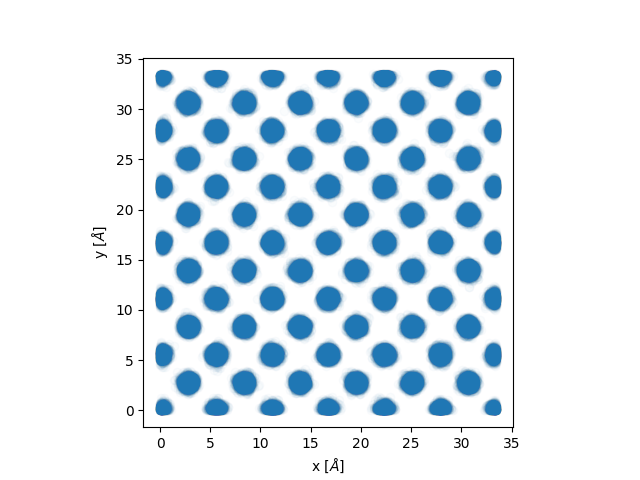

In [10]:
#plot atomic positions.
analyze_job = pr_cv.load('K1100_tdamp100_nprint40_fcc_6_strain1_0')
pos = analyze_job['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.2
fig, axs = plt.subplots(1,1)
axs.scatter(x[sel], y[sel], alpha=0.02)
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box')

In [15]:
delete_first = 200 # n_print steps
strain = 'strain1_0'
hcp_temp_arr, bcc_temp_arr, fcc_temp_arr = [], [], []
hcp_cv, bcc_cv, fcc_cv = [], [], []

for job_n in pr_cv.list_nodes():
    if not job_n.endswith(strain):
        continue
    analyze_job = pr_cv.load(job_n)
    print(job_n)
    T = analyze_job['output/generic/temperature'][delete_first:].mean()
    atom_number = analyze_job['output/generic/positions'].shape[1]
    if ('bcc' in job_n):
        bcc_temp_arr.append(T)        
        tot_energy = analyze_job['output/generic/energy_tot'][delete_first:]
        
        sm = tot_energy.mean()**2
        ms = np.multiply(tot_energy,tot_energy).mean()
        bcc_cv.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485 )        
        
        
    if ('hcp' in job_n):
        hcp_temp_arr.append(T)
        tot_energy = analyze_job['output/generic/energy_tot'][delete_first:]
        
        sm = tot_energy.mean()**2
        ms = np.multiply(tot_energy,tot_energy).mean()
        hcp_cv.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485 )

    if ('fcc' in job_n):
        fcc_temp_arr.append(T)
        tot_energy = analyze_job['output/generic/energy_tot'][delete_first:]
        
        sm = tot_energy.mean()**2
        ms = np.multiply(tot_energy,tot_energy).mean()
        fcc_cv.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485 )

K600_tdamp100_nprint40_fcc_6_strain1_0
K700_tdamp100_nprint40_fcc_6_strain1_0
K900_tdamp100_nprint40_fcc_6_strain1_0
K800_tdamp100_nprint40_fcc_6_strain1_0
K1100_tdamp100_nprint40_fcc_6_strain1_0
K1000_tdamp100_nprint40_fcc_6_strain1_0
K600_tdamp100_nprint40_bcc_7_strain1_0
K1100_tdamp100_nprint40_bcc_7_strain1_0
K1000_tdamp100_nprint40_bcc_7_strain1_0
K700_tdamp100_nprint40_bcc_7_strain1_0
K900_tdamp100_nprint40_bcc_7_strain1_0
K800_tdamp100_nprint40_bcc_7_strain1_0


In [20]:
fcc_cv

[25.098755967719022,
 25.271212590304415,
 26.03237628130356,
 26.337573716026025,
 26.32711559560513,
 26.36595555643103]

<IPython.core.display.Javascript object>


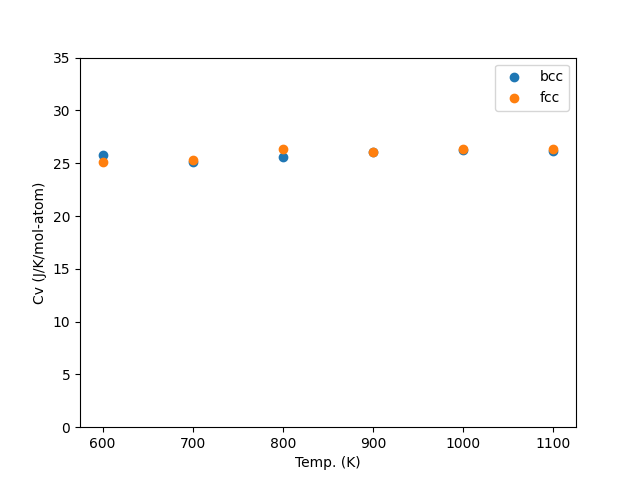

In [16]:
plt.figure()
plt.scatter(bcc_temp_arr,bcc_cv, label='bcc' ) 
plt.scatter(fcc_temp_arr,fcc_cv, label='fcc' ) 

plt.xlabel('Temp. (K)')
plt.ylabel('Cv (J/K/mol-atom)')
plt.ylim([0,35])
plt.legend()
plt.show()

## Check running mean of Cv of a job.

In [ ]:
jobs = pr_cv.list_nodes()
print(jobs)
selected_job = 'K1000_tdamp100_nprint40_fcc_6_strain1_0'

In [ ]:
delete_first = 100 # n_print steps
cv_arr = []

analyze_job = pr_cv.load(selected_job)
print(analyze_job.path)
T = int(analyze_job.name.split('_')[0][1:])
tot_energ = analyze_job['output/generic/energy_tot']
steps = np.arange(delete_first+2,len(tot_energ))
atom_number = analyze_job['output/generic/positions'].shape[1]
for i in steps:
    tot_energy = tot_energ[delete_first:int(i)]
    sm = tot_energy.mean()**2
    ms = np.multiply(tot_energy,tot_energy).mean()
    cv_arr.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485)
        
plt.figure()
plt.plot(steps, cv_arr)
minx, maxx = steps[0], steps[-1] 
plt.hlines(cv_arr[-1], minx, maxx, colors='k', linestyles='dashed')
plt.show()

# Create CP jobs

In [ ]:
# job_template = pr.create_group('CP').create_job(pr.job_type.Lammps, "lmp_template")
# job_template.potential = base_potential
# job_template.server.cores = 4
# job_template.server.queue = 'cmti'
# job_template.server.run_time = 200000

# pressure = 0.000101325 #GPa
# for structure in base_structures:
#     for temp in temp_list:
#         for tdamp in [100]:
#             for pdamp in [1000]:
#                 for nprint in [40]:
#                     job_name = 'K'+str(temp)+'_tdamp'+str(tdamp)+'_pdamp'+str(pdamp)+'_nprint'+str(nprint)+'_'+list(structure.info.keys())[0]
#                     # Run langevin first. For dissipation
#                     job = job_template.copy_to(new_job_name=job_name, new_database_entry=False)
                        
#                     strain_structure = structure.copy()
#                     job.structure = strain_structure                               
                    
#                     job.calc_md(temperature=temp, pressure=pressure, n_ionic_steps=1000000, n_print=nprint, 
#                                 temperature_damping_timescale=tdamp, pressure_damping_timescale=pdamp, langevin=False )
#                     job.run()

In [21]:
pr_cp = Project(path='heat_capacity_Ca1/CP')
print('Cp nodes:')
for i in pr_cp.list_nodes():
    print(i)
    
analyze_job_list = ['K1000_tdamp100_pdamp1000_nprint40_fcc_6', 'K1000_tdamp100_pdamp1000_nprint40_bcc_7']
jj = pr_cp.load(analyze_job_list[0])
jj['output/generic']

Cp nodes:
K600_tdamp100_pdamp1000_nprint40_fcc_6
K1000_tdamp100_pdamp1000_nprint40_fcc_6
K700_tdamp100_pdamp1000_nprint40_fcc_6
K800_tdamp100_pdamp1000_nprint40_fcc_6
K900_tdamp100_pdamp1000_nprint40_fcc_6
K1100_tdamp100_pdamp1000_nprint40_fcc_6
K600_tdamp100_pdamp1000_nprint40_bcc_7
K800_tdamp100_pdamp1000_nprint40_bcc_7
K900_tdamp100_pdamp1000_nprint40_bcc_7
K700_tdamp100_pdamp1000_nprint40_bcc_7
K1000_tdamp100_pdamp1000_nprint40_bcc_7
K1100_tdamp100_pdamp1000_nprint40_bcc_7


{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

In [ ]:
# plot a property versus md steps of jobs @
# analyze_job_list.
porperty = 'temperature'
clist=['b', 'r', 'g']
plt.figure()
for e,analyze_job_name in enumerate(analyze_job_list):
    c=clist[e]
    analyze_job = pr_cp.load(analyze_job_name)
    properties = analyze_job['output/generic/' + porperty]
    steps = analyze_job['output/generic/steps']
    plt.plot(steps, properties,label=analyze_job_name,color=c,alpha=0.5)


plt.xlabel('MD step')
plt.ylabel(porperty)
plt.legend()

In [ ]:
# plot property distributionof jobs @
# analyze_job_list.
delete_first = 200 # steps
porperty = 'energy_tot'
plt.figure()
for e,analyze_job_name in enumerate(analyze_job_list):
    c=clist[e]
    analyze_job = pr_cp.load(analyze_job_name)
    properties = analyze_job['output/generic/' + porperty]
    properties = properties[delete_first:]
    plt.hist(properties, bins=30,label=analyze_job_name,density=True,color=c,alpha=0.5)
    print(properties.mean())
    print(properties.std())
    pdf_x = np.linspace(np.min(properties),np.max(properties),100)
    pdf_y = 1.0/np.sqrt(2*np.pi*properties.std()**2)*np.exp(-0.5*(pdf_x-properties.mean())**2/(properties.std()**2))
    plt.plot(pdf_x,pdf_y,color=c, linestyle='dashed')
plt.legend(bbox_to_anchor=(0, 1.0), loc="lower left")
plt.show()

In [ ]:
#plot atomic positions.
analyze_job = pr_cp.load('K1000_tdamp100_pdamp1000_nprint40_fcc_6')
pos = analyze_job['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.2
fig, axs = plt.subplots(1,1)
axs.scatter(x[sel], y[sel], alpha=0.01)
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box')

In [22]:
delete_first = 200 # n_print steps
hcp_temp_arr, bcc_temp_arr, fcc_temp_arr = [], [], []
hcp_cp, bcc_cp, fcc_cp = [], [], []

## BE SURE THAT THE PRESSURE IS THE SAME WHILE SAMPLING
pressure = 0.000101325 #GPa
for job_n in pr_cp.list_nodes():

    analyze_job = pr_cp.load(job_n)
    print(job_n)
    T = analyze_job['output/generic/temperature'][delete_first:].mean()
    atom_number = analyze_job['output/generic/positions'].shape[1]
    if ('bcc' in job_n):
        bcc_temp_arr.append(T)        
        tot_energy = analyze_job['output/generic/energy_tot'][delete_first:] + analyze_job['output/generic/volume'][delete_first:]*pressure*6.242*1e-3
        
        sm = tot_energy.mean()**2
        ms = np.multiply(tot_energy,tot_energy).mean()
        bcc_cp.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485)        
        
        
    if ('hcp' in job_n):
        hcp_temp_arr.append(T)
        tot_energy = analyze_job['output/generic/energy_tot'][delete_first:] + analyze_job['output/generic/volume'][delete_first:]*pressure*6.242*1e-3
        
        sm = tot_energy.mean()**2
        ms = np.multiply(tot_energy,tot_energy).mean()
        hcp_cp.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485)

    if ('fcc' in job_n):
        fcc_temp_arr.append(T)
        tot_energy = analyze_job['output/generic/energy_tot'][delete_first:] + analyze_job['output/generic/volume'][delete_first:]*pressure*6.242*1e-3
        
        sm = tot_energy.mean()**2
        ms = np.multiply(tot_energy,tot_energy).mean()
        fcc_cp.append((ms - sm)/8.617/1e-5/T/T/atom_number*96485)

K600_tdamp100_pdamp1000_nprint40_fcc_6
K1000_tdamp100_pdamp1000_nprint40_fcc_6
K700_tdamp100_pdamp1000_nprint40_fcc_6
K800_tdamp100_pdamp1000_nprint40_fcc_6
K900_tdamp100_pdamp1000_nprint40_fcc_6
K1100_tdamp100_pdamp1000_nprint40_fcc_6
K600_tdamp100_pdamp1000_nprint40_bcc_7
K800_tdamp100_pdamp1000_nprint40_bcc_7
K900_tdamp100_pdamp1000_nprint40_bcc_7
K700_tdamp100_pdamp1000_nprint40_bcc_7
K1000_tdamp100_pdamp1000_nprint40_bcc_7
K1100_tdamp100_pdamp1000_nprint40_bcc_7


In [29]:
np.array(result_fcc['T'])

array([600. , 600.1, 600.2, ..., 715.7, 715.8, 715.9])

<IPython.core.display.Javascript object>


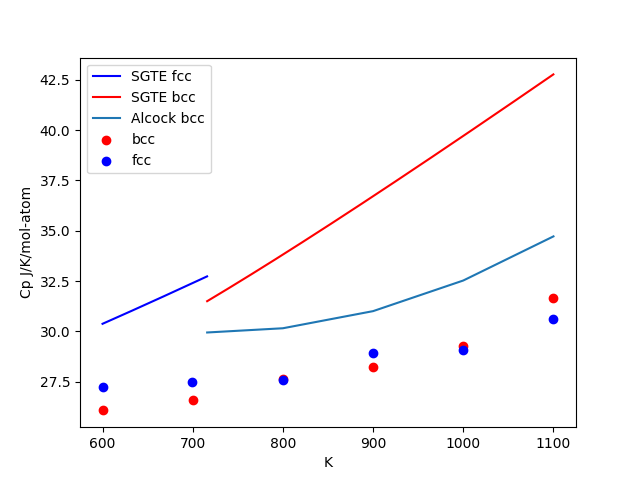

fcc : [600.0508053507384, 1000.0802499923194, 699.6631644248363, 800.0376257972823, 899.9795902749739, 1099.9782473102582] [27.254846840434663, 29.09042665335003, 27.504779462408393, 27.593282742959218, 28.9384207646372, 30.634361007137414]
bcc : [600.016969183839, 800.0901046960076, 900.155263589008, 700.013193209919, 1000.0616007959457, 1099.9894383915107] [26.082826058639306, 27.633575197269224, 28.238919721567502, 26.586669999911788, 29.301660855838694, 31.648244444266805]


In [23]:
result_fcc = calculate(db, ['CA', 'VA'], 'FCC_A1', T=(600, 716, 0.1), P=101325, N=1, output='heat_capacity')
result_bcc = calculate(db, ['CA', 'VA'], 'BCC_A2', T=(716, 1100, 0.1), P=101325, N=1, output='heat_capacity')

plt.figure()
plt.scatter(bcc_temp_arr,bcc_cp, label='bcc', c='r' ) 
plt.scatter(fcc_temp_arr,fcc_cp, label='fcc', c='b' ) 
plt.plot(result_fcc['T'], np.squeeze(1.0 * result_fcc['heat_capacity']), label='SGTE fcc', c='b')
plt.plot(result_bcc['T'], np.squeeze(1.0 * result_bcc['heat_capacity']), label='SGTE bcc', c='r')
plt.plot([716, 800, 900,1000,1100], [29.95,30.16, 31.01, 32.53,34.72], label='Alcock bcc')
plt.xlabel('K')
plt.ylabel('Cp J/K/mol-atom')
#plt.ylim([0,35])
plt.legend()
plt.show()
print('fcc :',fcc_temp_arr,fcc_cp )
print('bcc :',bcc_temp_arr,bcc_cp )

<IPython.core.display.Javascript object>


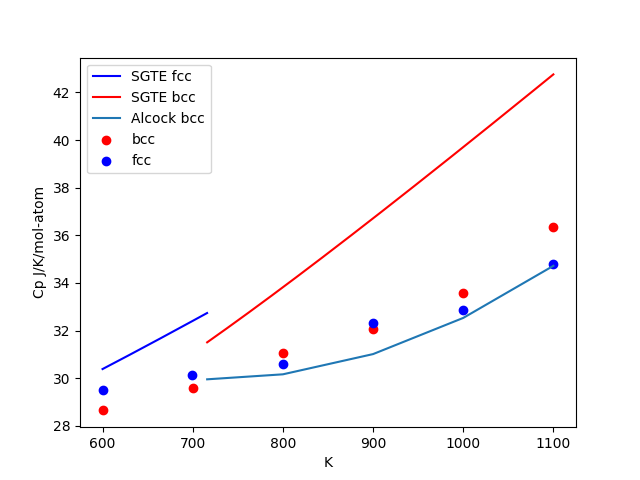

In [34]:
result_fcc = calculate(db, ['CA', 'VA'], 'FCC_A1', T=(600, 716, 0.1), P=101325, N=1, output='heat_capacity')
result_bcc = calculate(db, ['CA', 'VA'], 'BCC_A2', T=(716, 1100, 0.1), P=101325, N=1, output='heat_capacity')

# sorted according to temp_arr 
e_cv_fcc = np.array([2.26553472, 3.77589119, 2.64312384, 3.02071295, 3.39830207, 4.15348031 ])
e_cv_bcc = np.array([2.56133851, 3.41460163, 3.84204553, 2.98842565, 4.26817691, 4.6975527 ])

bcc_cp_sum = e_cv_bcc + np.array(bcc_cp)
fcc_cp_sum = e_cv_fcc + np.array(fcc_cp)

plt.figure()
plt.scatter(bcc_temp_arr,bcc_cp_sum, label='bcc', c='r' ) 
plt.scatter(fcc_temp_arr,fcc_cp_sum, label='fcc', c='b' ) 
plt.plot(result_fcc['T'], np.squeeze(1.0 * result_fcc['heat_capacity']), label='SGTE fcc', c='b')
plt.plot(result_bcc['T'], np.squeeze(1.0 * result_bcc['heat_capacity']), label='SGTE bcc', c='r')
plt.plot([716, 800, 900,1000,1100], [29.95,30.16, 31.01, 32.53,34.72], label='Alcock bcc')
plt.xlabel('K')
plt.ylabel('Cp J/K/mol-atom')
#plt.ylim([0,35])
plt.legend()
plt.show()

In [33]:
save('SGTE_fcc_temp.npy', np.array(result_fcc['T']))
save('SGTE_bcc_temp.npy', np.array(result_bcc['T']))

save('SGTE_fcc_cp.npy', np.array(result_fcc['heat_capacity']).reshape(-1))
save('SGTE_bcc_cp.npy', np.array(result_bcc['heat_capacity']).reshape(-1))